In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
class NumberLineSystem:
    """
    1D particle system with collision and potential field.

    State: x[t] = [y[t], v[t]]
    Input: u[t] ∈ [-1, 1]
    Output: z[t] = y[t] + measurement noise
    """

    def __init__(self, m=1, p_c=0.1, p_w=0.05, v_max=3, y0=0, v0=0, A=1, y_max=3, noise=False):
        self.m = m
        self.p_c = p_c
        self.p_w = p_w
        self.v_max = v_max
        self.y = y0
        self.v = v0 + self.d_v_noise(v0)

        self.noise = noise
        self.z = self.y
        if self.noise is True:
          self.z += np.random.normal(0, 0.25*self.v**2)

        self.history = {'y': [y0], 'v': [v0], 'u':[0], 'z': self.z}
        self.A = A # Amplitude
        self.y_max = y_max

 

    def d_v_noise(self, v):
        """
        Implements the d(v) function using numpy's choice function
        """
        speed = abs(v)
        
        outcomes = [1, 0, -1]
        
        p1 = (speed / self.v_max) * (self.p_w / 2)
        p0 = 1 - (speed / self.v_max) * self.p_w
        p_minus1 = (speed / self.v_max) * (self.p_w / 2)
        
        probabilities = [p1, p0, p_minus1]

        return np.random.choice(outcomes, p=probabilities)

    def f_phi(self, y):
        return int(self.A*np.sin(2*np.pi*y/self.y_max))

    def crash_probability(self, v):
        return self.p_c * abs(v) / self.v_max

    def step(self, u):
        # Apply collision dynamics
        p_crash = self.crash_probability(self.v)

        v_no_crash = self.v + (u + self.f_phi(self.y)) / self.m
        v_crash = 0
        outcomes = [v_no_crash, v_crash]

        # P(v_no_crash) = 1 - p_crash
        # P(v_crash) = p_crash
        probabilities = [1 - p_crash, p_crash]

        self.v = np.random.choice(outcomes, p=probabilities)

        if self.noise is True:
         self.v += self.d_v_noise(self.v)

        # Apply position dynamics
        if abs(self.v) > self.v_max:
            self.v = np.sign(self.v) * self.v_max
        self.y = self.y + self.v
        if abs(self.y) > self.y_max:
            self.y = np.sign(self.y) * self.y_max

        # Update output
        self.z = self.y
        if self.noise is True:
          self.z += np.random.normal(0, 0.25*self.v**2)

        self.history['y'].append(self.y)
        self.history['z'].append(self.z)
        self.history['v'].append(self.v)
        self.history['u'].append(u)

    def simulate(self, inputs):
        # Reset history for a new simulation
        self.z = self.history['y'][0]
        if self.noise is True:
          self.z += np.random.normal(0, 0.25*self.history['v'][0]**2)

        self.history = {'y': [self.history['y'][0]], 'v': [self.history['v'][0]], 'u': [self.history['u'][0]], 'z': [self.z]}
        results = []
        for u in inputs:
            if u not in [-1, 0, 1]:
              raise ValueError(f"Invalid input: {u}. Input must be -1, 0, or 1.")
            results.append(self.step(u))

        # Save to a .csv file using pandas
        T = len(system.history['y'])
        df = pd.DataFrame({
            'Time': range(T),
            'Position_y': [f"{val:.4f}" for val in self.history['y']],
            'Velocity_v': [f"{val:.4f}" for val in self.history['v']],
            'Input_u': [f"{val:.4f}" for val in self.history['u']],
            'Output_z': [f"{val:.4f}" for val in self.history['z']]
        })
        df.to_csv('number_line_sim.csv', index=False)

        return results

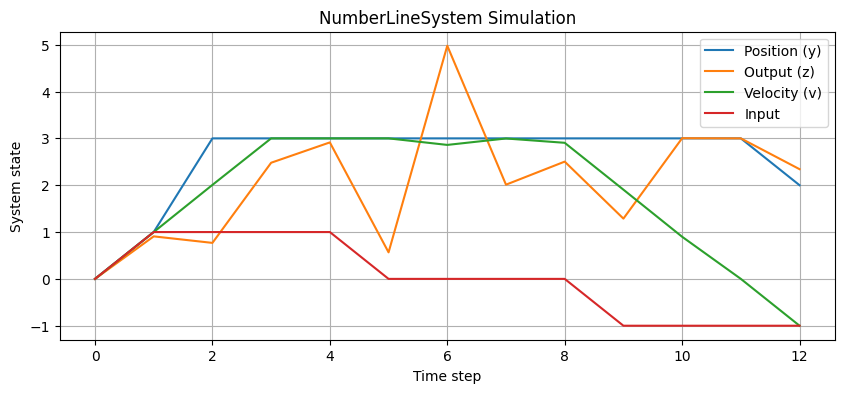

In [ ]:
system = NumberLineSystem()    # instantiate the class
# input_seq = np.random.uniform(-1, 1, 10_000)     # generate some random inputs
input_seq = [1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1]
system.simulate(input_seq)                   # run simulation

T = len(system.history['y'])  # Number of (simulated) timesteps

plt.figure(figsize=(10,4))
plt.plot(range(T), system.history['y'], label='Position (y)')
plt.plot(range(T), system.history['z'], label='Output (z)')
plt.plot(range(T), system.history['v'], label='Velocity (v)')
plt.plot(range(T), system.history['u'], label='Input')
plt.xlabel('Time step')
plt.ylabel('System state')
plt.title('NumberLineSystem Simulation')
plt.legend()
plt.grid(True)
plt.show()